# Levenshtein distance and spelling corrections

#### 1. Use SpaCy tokenizer API to tokenize the text from the law corpus.
https://spacy.io/usage

python -m venv .env

source .env/bin/activate

conda install -c conda-forge spacy

python -m spacy download pl_core_news_sm

In [79]:
import os
import spacy
from collections import Counter


nlp = spacy.load("pl_core_news_sm")


def tokenize_data():
    docs = []
    directory = '../ustawa/'
    file_list = os.listdir(os.getcwd() + '/' + directory)

    for filename in file_list:
        with open(os.path.join(directory + filename), 'r') as file:
            infile = file.read()
            doc_ = nlp(infile, disable=["tagger", "parser"])
            docs.append([filename, doc_])
    return docs


tokenized = tokenize_data()


for doc in tokenized:
    for token in doc[1]:
        print(token.text, token.pos_)

abakański 
, 
abakański 
, 
abakański 
, 
abakański 
, 
abakański 
, 
aa 
, 
bb 
, 
bb 
, 
bb 
, 
bb 
, 
bb 
, 
Abchazon 
, 
Abchazon 
, 
Abchazon 
, 
Abchazon 
, 
Abchazon 
, 
abadański 
, 
abadański 
, 
abadański 
, 
abadański 
, 
abadański 
, 
abadańska1 
, 
  SPACE
abadańska1 
, 
abadańska1 
, 
abadańska1 
, 
abadańska1 


#### 2. Compute frequency list for each of the processed files.
#### 3. Aggregate the result to obtain one global frequency list.

In [80]:
from collections import defaultdict
freqlist = defaultdict(int)
for doc in tokenized:
    for token in doc[1]:
        freqlist[token.text.lower()]+=1

In [ ]:
print(freqlist)

#### 4. Reject all entries that are shorter than 2 characters or contain non-letter characters (make sure to include Polish diacritics).

In [81]:
import re
to_remove = []
for token, _ in freqlist.items():
    if len(token) < 2 or re.findall(re.compile(r'([^a-ząćęłńóśżź])'), token):
        to_remove.append(token)

for token in to_remove:
    del freqlist[token]

In [ ]:
print(freqlist)

##### 5. Make a plot in a logarithmic scale (for X and Y):
   1. X-axis should contain the **rank** of a term, meaning the first rank belongs to the term with the highest number of
      occurrences; the terms with the same number of occurrences should be ordered by their name,
   2. Y-axis should contain the **number of occurrences** of the term with given rank.

Text(0.5, 1.0, 'Ilość wystąpień wyrazów')

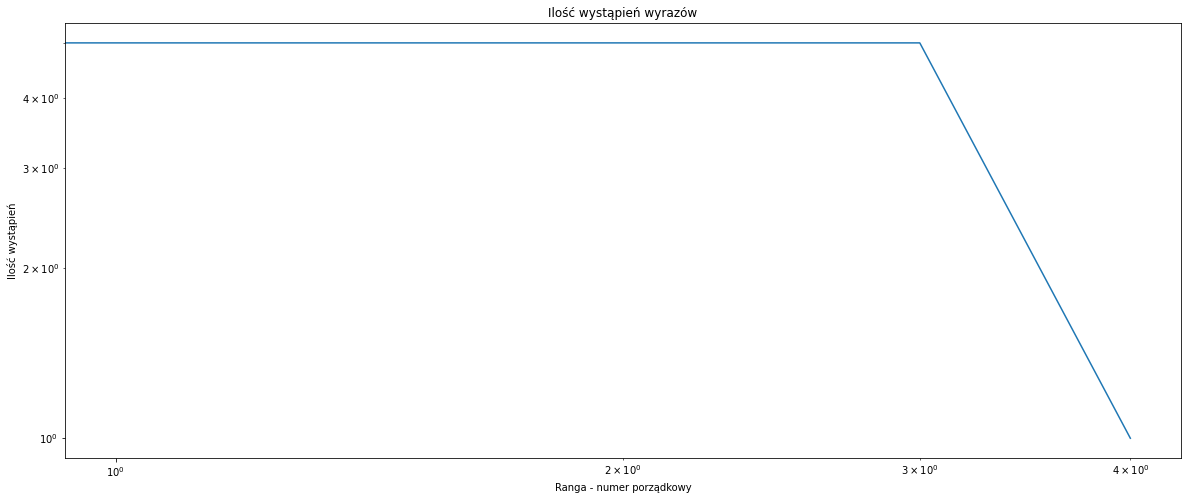

In [82]:
import matplotlib.pylab as plt

data = sorted(freqlist.values(), reverse=True)

plt.figure(figsize=(20,8))
plt.plot(data)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Ranga - numer porządkowy')
plt.ylabel('Ilość wystąpień')
plt.title("Ilość wystąpień wyrazów")

 > Według Prawa Zipfa dla dowolnego języka wykaz wyrazów ułożonych w malejącym porządku częstotliwości ich występowania, ranga (numer porządkowy) wyrazu jest odwrotnie proporcjonalna do częstotliwości.
 > Wykres zgodny z oczekiwaniem, zbliżony do prostej.

6. Install [Morfeusz](http://morfeusz.sgjp.pl/download/) (Binding dla Pythona) and use it to find all words that do not
   appear in that dictionary.

   Skorzystałem z:
   http://download.sgjp.pl/morfeusz/20210110/polimorf-20210110.tab.gz

In [83]:
import pandas as pd

polimorf = pd.read_csv('polimorf_s.txt', sep='	', header=None, names=['word', 'inflection', 'info'], skiprows=0)

polimorf

,word,inflection,info
0,a,a,interj
1,a,a,part
2,a,a,conj
3,a,a,prep:nom
4,aa,aa,interj
...,...,...,...
256,abakańczyku,abakańczyk,subst:sg:voc:m1
257,abakańscy,abakański,adj:pl:nom.voc:m1:pos
258,abakańska,abakański,adj:sg:nom.voc:f:pos
259,abakańską,abakański,adj:sg:acc:f:pos


7. Find 30 words with the highest ranks that do not belong to the dictionary.

In [84]:
polimorf_flect = polimorf[['word']].applymap(lambda w: w.lower()).values.tolist()

In [85]:
freqlist_sorted = sorted(freqlist.items(), reverse=True)
freqlist_sorted

[('bb', 5), ('abchazon', 5), ('abakański', 5), ('abadański', 5), ('aa', 1)]

In [86]:
not_belong = [word for word in freqlist_sorted if [word] not in polimorf_flect]
not_belong[:30]

[('bb', 5), ('abchazon', 5), ('abakański', 5), ('abadański', 5), ('aa', 1)]

8. Find 30 random words (i.e. shuffle the words) with 5 occurrences that do not belong to the dictionary.

In [87]:
not_belong_5oc = [word[0] for word in not_belong if word[1] == 5][:30]
not_belong_5oc

['bb', 'abchazon', 'abakański', 'abadański']

9. Use Levenshtein distance and the frequency list, to determine the most probable correction of the words from the
   second list. (You don't have to apply the distance directly. Any method that is more efficient than scanning the
   dictionary will be appreciated.)

>skorzystałem z: http://stevehanov.ca/blog/?id=114

In [92]:
# The Trie data structure keeps a set of words, organized with one node for
# each letter. Each node has a branch for each letter that may follow it in the
# set of words.
class TrieNode:
    def __init__(self):
        self.word = None
        self.children = {}

    def insert( self, word ):
        node = self
        for letter in word:
            if letter not in node.children:
                node.children[letter] = TrieNode()

            node = node.children[letter]

        node.word = word

    # The search function returns a list of all words that are less than the given
    # maximum distance from the target word
    def search(self, word, maxCost ):

        # build first row
        currentRow = range( len(word) + 1 )

        results = []

        # recursively search each branch of the trie
        for letter in self.children:
            self.searchRecursive( self.children[letter], letter, word, currentRow,
                results, maxCost )

        return results

    # This recursive helper is used by the search function above. It assumes that
    # the previousRow has been filled in already.
    def searchRecursive(self, node, letter, word, previousRow, results, maxCost ):

        columns = len( word ) + 1
        currentRow = [ previousRow[0] + 1 ]

        # Build one row for the letter, with a column for each letter in the target
        # word, plus one for the empty string at column 0
        for column in range( 1, columns ):

            insertCost = currentRow[column - 1] + 1
            deleteCost = previousRow[column] + 1

            if word[column - 1] != letter:
                replaceCost = previousRow[ column - 1 ] + 1
            else:
                replaceCost = previousRow[ column - 1 ]

            currentRow.append( min( insertCost, deleteCost, replaceCost ) )

        # if the last entry in the row indicates the optimal cost is less than the
        # maximum cost, and there is a word in this trie node, then add it.
        if currentRow[-1] <= maxCost and node.word != None:
            results.append( (node.word, currentRow[-1] ) )

        # if any entries in the row are less than the maximum cost, then
        # recursively search each branch of the trie
        if min( currentRow ) <= maxCost:
            for letter in node.children:
                self.searchRecursive( node.children[letter], letter, word, currentRow,
                    results, maxCost )

In [93]:
tri = TrieNode()

for word in freqlist.keys():
    tri.insert(word)
    

In [94]:
MAX_LENGTH = 10

for word in not_belong_5oc:
    recons = tri.search(word, MAX_LENGTH)
    recons = list(filter(lambda s: s[1] != 0, recons))
    recons.sort(key=lambda f: f[1])
    recons = recons[:3]
    
    print(f'{word}: {recons}')

bb: [('aa', 2), ('abchazon', 7), ('abakański', 8)]
abchazon: [('abakański', 6), ('abadański', 6), ('aa', 6)]
abakański: [('abadański', 1), ('abchazon', 6), ('aa', 7)]
abadański: [('abakański', 1), ('abchazon', 6), ('aa', 7)]


10. Load [SGJP dictionary](http://morfeusz.sgjp.pl/download/) (Słownik SGJP dane tekstowe) to ElasticSearch (one document for each form)
   and use fuzzy matching to obtain the possible
   corrections of the 30 words with 5 occurrences that do not belong to the dictionary.

   Skorzystałem z:
   http://download.sgjp.pl/morfeusz/20210110/polimorf-20210110.tab.gz

## Install ElasticSearch (ES).
### install elasticsearch on Ubunt
https://www.elastic.co/guide/en/elasticsearch/reference/current/deb.html
sudo apt-get install elasticsearch=7.9.2
## Install an ES plugin for Polish https://github.com/allegro/elasticsearch-analysis-morfologik
## install Morfologik in eleasticsearch directory - use the same version as elasticsearch
cd /usr/share/elasticsearch
sudo bin/elasticsearch-plugin install pl.allegro.tech.elasticsearch.plugin:elasticsearch-analysis-morfologik:7.9.2

## restart
sudo -i service elasticsearch start
sudo -i service elasticsearch stop

## check if working
curl -XGET "http://localhost:9200/_analyze?pretty" -H 'Content-Type: application/json' -d '{ "analyzer": "morfologik", "text": "jestem" }'

In [ ]:
import pandas as pd

polimorf = pd.read_csv('polimorf_s.txt', sep='	', header=None, names=['word', 'inflection', 'info'], skiprows=0)
polimorf

In [ ]:
polimorf_flect = polimorf[['word']].applymap(lambda w: w.lower()).values.flatten().tolist()
polimorf_flect = list(set(polimorf_flect))

In [95]:
from elasticsearch import Elasticsearch, helpers
import csv

es = Elasticsearch()

def gendata():
    for word in polimorf_flect:
        yield {
            "_index": "polimorf",
            "word": word,
        }

with open('polimorf_s.txt', encoding='utf-8') as file:
    helpers.bulk(es, gendata())


BulkIndexError: ('261 document(s) failed to index.', [{'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'AmyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['a']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'A2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['a']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'BGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['a']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'BWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['a']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'BmyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aa']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'B2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aa']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'CGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aa']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'CWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aa']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'CmyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aachen']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'C2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aachen']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'DGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aalborg']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'DWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aalborgach']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'DmyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aalborgami']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'D2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aalborgi']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'EGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aalborgiem']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'EWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aalborgom']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'EmyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aalborgowi']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'E2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aalborgów']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'FGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aalborgu']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'FWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aalborgu']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'FmyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aalborgu']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'F2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aap']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'GGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aar']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'GWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aarach']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'GmyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aarami']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'G2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aarem']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'HGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aarom']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'HWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aarowi']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'HmyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aarów']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'H2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaru']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'IGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aary']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'IWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aarze']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'ImyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aarze']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'I2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aara']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'JGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aar']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'JWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aarach']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'JmyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aarami']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'J2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aarą']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'KGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aarę']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'KWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaro']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'KmyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aarom']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'K2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aary']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'LGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aary']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'LWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aarze']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'LmyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aarona']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'L2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaron']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'MGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronach']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'MWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronami']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'MmyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronem']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'M2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaroni']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'NGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronie']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'NWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronie']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'NmyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronom']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'N2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronowi']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'OGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronowie']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'OWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronów']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'OmyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aarony']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'O2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronowa']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'PGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronową']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'PWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronową']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'PmyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronowe']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'P2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronowe']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'QGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronowe']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'QWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronowe']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'QmyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronowego']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'Q2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronowego']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'RGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronowej']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'RWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronowej']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'RmyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronowej']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'R2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronowemu']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'SGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronowi']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'SWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronowo']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'SmyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronowy']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'S2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronowy']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'TGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronowych']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'TWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronowych']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'TmyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronowych']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'T2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronowym']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'UGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronowym']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'UWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronowym']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'UmyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaronowymi']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'U2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aasena']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'VGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aasen']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'VWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aasenach']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'VmyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aasenami']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'V2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aasenem']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'WGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aasenie']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'WWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aasenie']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'WmyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aasenom']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'W2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aasenowi']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'XGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aasenowie']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'XWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aasenów']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'XmyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['aaseny']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'X2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abacja']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'YGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abacjach']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'YWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abacjami']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'YmyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abacją']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'Y2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abacje']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'ZGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abację']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'ZWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abacji']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'ZmyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abacji']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'Z2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abacji']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'aGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abacjo']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'aWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abacjom']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'amyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abacyj']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'a2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadan']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'bGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadanach']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'bWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadanami']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'bmyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadanem']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'b2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadanie']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'cGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadanie']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'cWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadanom']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'cmyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadanowi']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'c2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadanów']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'dGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadanu']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'dWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadany']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'dmyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadance']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'd2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadanek']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'eGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadanka']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'eWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadankach']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'emyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadankami']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'e2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadanką']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'fGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadankę']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'fWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadanki']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'fmyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadanki']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'f2yWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadanko']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'gGyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadankom']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'gWyWFncB6GfxihSJ0DwQ', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańczycy']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'gmyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańczyka']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'g2yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańczyk']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'hGyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańczykach']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'hWyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańczykami']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'hmyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańczyki']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'h2yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańczykiem']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'iGyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańczykom']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'iWyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańczykowi']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'imyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańczyków']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'i2yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańczyku']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'jGyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańczyku']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'jWyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańscy']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'jmyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańska']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'j2yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańską']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'kGyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańską']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'kWyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadański']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'kmyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadański']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'k2yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańskich']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'lGyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańskich']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'lWyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańskich']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'lmyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańskie']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'l2yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańskie']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'mGyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańskie']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'mWyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańskie']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'mmyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańskiego']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'm2yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańskiego']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'nGyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańskiej']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'nWyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańskiej']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'nmyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańskiej']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'n2yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańskiemu']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'oGyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańskim']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'oWyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańskim']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'omyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańskim']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'o2yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańskimi']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'pGyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańsko']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'pWyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abadańsku']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'pmyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abaddona']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'p2yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abaddon']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'qGyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abaddonach']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'qWyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abaddonami']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'qmyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abaddonem']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'q2yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abaddonie']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'rGyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abaddonie']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'rWyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abaddonom']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'rmyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abaddonowi']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'r2yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abaddonowie']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'sGyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abaddonów']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'sWyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abaddony']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'smyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abaka']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 's2yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abak']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'tGyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakach']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'tWyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakami']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'tmyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abaki']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 't2yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakiem']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'uGyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakom']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'uWyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakowi']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'umyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abaków']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'u2yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abaku']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'vGyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abaku']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'vWyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abace']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'vmyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abaka']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'v2yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abak']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'wGyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakach']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'wWyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakami']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'wmyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abaką']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'w2yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakę']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'xGyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abaki']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'xWyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abaki']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'xmyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abako']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'x2yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakom']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'yGyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakan']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'yWyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanach']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'ymyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanami']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'y2yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanem']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'zGyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanie']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'zWyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanie']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'zmyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanom']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'z2yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanowi']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '0GyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanów']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '0WyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanu']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '0myWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakany']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '02yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakan']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '1GyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanach']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '1WyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanami']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '1myWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanem']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '12yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanie']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '2GyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanie']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '2WyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanom']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '2myWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanowi']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '22yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanów']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '3GyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanu']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '3WyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakany']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '3myWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakance']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '32yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanek']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '4GyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanka']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '4WyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakankach']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '4myWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakankami']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '42yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanką']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '5GyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakankę']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '5WyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanki']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '5myWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanki']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '52yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanko']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '6GyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakankom']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '6WyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanowicza']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '6myWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanowicz']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '62yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanowiczach']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '7GyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanowiczami']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '7WyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanowicze']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '7myWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanowicze']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '72yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanowiczem']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '8GyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanowiczom']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '8WyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanowiczowi']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '8myWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanowiczowie']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '82yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanowiczów']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '9GyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanowiczu']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '9WyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanowiczu']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '9myWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakanowicz']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '92yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakańczycy']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '-GyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakańczyka']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '-WyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakańczyk']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '-myWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakańczykach']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '-2yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakańczykami']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '_GyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakańczyki']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '_WyWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakańczykiem']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '_myWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakańczykom']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': '_2yWFncB6GfxihSJ0DwR', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakańczykowi']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'AGyWFncB6GfxihSJ0D0R', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakańczyków']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'AWyWFncB6GfxihSJ0D0R', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakańczyku']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'AmyWFncB6GfxihSJ0D0R', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakańczyku']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'A2yWFncB6GfxihSJ0D0R', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakańscy']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'BGyWFncB6GfxihSJ0D0R', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakańska']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'BWyWFncB6GfxihSJ0D0R', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakańską']}}}, {'index': {'_index': 'polimorf', '_type': '_doc', '_id': 'BmyWFncB6GfxihSJ0D0R', 'status': 429, 'error': {'type': 'cluster_block_exception', 'reason': 'index [polimorf] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];'}, 'data': {'word': ['abakańską']}}}])

In [96]:
for word in not_belong_5oc:
    req = {
        "query" : {
            "fuzzy" : {
                "inf" : {
                    "value": word,
                    "fuzziness" : "AUTO"

                }
            }
        }
    }
    res = es.search(index='polimorf', body=req, size=3, _source='inf')
    # , filter_path=['hits.hits._source']
    if bool(res):
        corr = [hits for hit in res['hits']['hits'] for hits in hit['_source'].values()]
        print(f'{word}: {corr}')
    else:
        print(f'{word}: BRAK')

bb: []
abchazon: []
abakański: []
abadański: []


In [ ]:
# print indicies
for index in es.indices.get('*'):
  print(index)

In [ ]:
# delate index
# res = es.indices.delete(index='polimorf', ignore=[400, 404])
# print(res)

In [ ]:
indices = es.indices.get('*')
print(indices)

sprawdzenie zawartości indeksu
> curl -H 'Content-Type: application/json' -X GET http://localhost:9200/polimorf/_search?pretty

11. Compare the results of your algorithm and output of ES.

12. Draw conclusions regarding:
   * the distribution of words in the corpus,
   >
   * the number of true misspellings vs. the number of unknown words,
   >
   * the performance of your method compared to ElasitcSearch,
   >
   * the results provided by your method compared to ElasticSearch,
   >
   * the validity of the obtained corrections.
   >

## Hints

1. Levenshtein distance (Edit distance) is a measure defined for any pair of strings. It is defined as the minimal
   number of single character edits (insertions, deletions or substitutions) needed to transform one string to the
   other. The measure is symmetric.
1. The algorithm is usually implemented as a dynamic program, see [Wikipedia article](https://en.wikipedia.org/wiki/Levenshtein_distance)
   for details.
1. The distance may be used to fix an invalid word by inspecting in the growing order of the distance, the words
   that are *n* edits away from the invalid word. If there are no words *n* edits away, the words *n+1* edits away
   are inspected.
1. The frequency list may be used to select the most popular word with given distance, if there are many candidate
   corrections.
1. Usually the correction algorithm does not use the edit distance directly, since it would require to compare the
   invalid word with all words in the dictionary. The algorithms work in the opposite way - the generate candidate words
   that are 1 or 2 edits away from the invalid word (cf. P. Norvigs [article](https://norvig.com/spell-correct.html)
   for the details). A different approach is to use [Levenshtein automaton](https://norvig.com/spell-correct.html) for
   finding the corrections effectively.
1. ElasticSearch has a [fuzziness](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-fuzzy-query.html)
   parameter for finding approximate matches of a query.
